# Getting Started

Here, we load in all required packages, the data and if necesssary, additional annotations.

## Load Packages

Load in all relevant packages and set the python paths. Configure plotting parameters, set a directory for figures, results and the data.

In [1]:
# only want to see warning once
import warnings
warnings.filterwarnings(action='once') 

In [2]:
# import standard packages
import numpy as np
import re

In [3]:
# import scanpy, scvelo and velocyto
import scanpy.api as sc
import scvelo as scv

/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/site-packages/igraph/configuration.py:288: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  self._config = SafeConfigParser()
/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/michal/.local/miniconda3/envs/

In [4]:
# logging
scv.logging.print_versions()

scvelo==0.1.17  scanpy==1.4  anndata==0.6.18  loompy==2.0.17  numpy==1.15.4  scipy==1.2.0  matplotlib==3.0.2  sklearn==0.20.2  pandas==0.23.4  


In [5]:
import sys  
path_to_interactive_plotting = ...
sys.path.insert(0, path_to_interactive_plotting)

import interactive_plotting as ipl  
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [6]:
# parameters for scvelo and scanpy
scv.settings.set_figure_params(frameon = True, style='scvelo')
sc.settings.verbosity = 0

In [7]:
# check the figures directories
scv.settings.figdir, sc.settings.figdir

('./figures/', './figures/')

In [8]:
np.random.seed(42)

## Import Data

In [9]:
# import data
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical


In [10]:
# make unique
adata.var_names_make_unique()

In [11]:
# cell and gene numbers
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

In [12]:
# spliced and unspliced numbers
scv.utils.show_proportions(adata)

Abundance of []: []


## Additional Annotations

Import additionall annotations. Ideally, the path would be stored in ```paths```, or given relative to the ```base_path```.

In [13]:
# label mitochondtial genes
regex = re.compile('^(mt).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
adata.var['mito'] = False
adata.var.loc[mito_genes, 'mito'] = True
print('Found {} mito genes and annotated.'.format(len(mito_genes)))

Found 15 mito genes and annotated.


In [14]:
mito_genes[:5]

['Mt1', 'Mt2', 'Mta1', 'Mta2', 'Mta3']

In [15]:
# label batches
adata.obs['batch'] = '1'
adata.obs.loc[adata.obs_names[:int(adata.n_obs/2)], 'batch'] = '0'

In [16]:
# compute qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)
adata.obs.head()

,paul15_clusters,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
0,7MEP,0,277,5.627621,353.0,5.869297,33.427762,49.858357,78.186969,100.000000,0.0,0.000000,0.000000
1,15Mo,0,1021,6.929517,2556.0,7.846590,31.259781,41.979656,55.555556,79.616588,9.0,2.302585,0.352113
2,3Ery,0,1466,7.290975,4649.0,8.444622,22.112282,31.490643,44.246074,68.186707,43.0,3.784190,0.924930
3,15Mo,0,1415,7.255591,4486.0,8.408939,27.440927,36.714222,49.264378,71.912617,11.0,2.484907,0.245207
4,3Ery,0,1505,7.317212,5205.0,8.557567,21.690682,30.605187,43.342939,67.877041,45.0,3.828641,0.864553


## Quality Control

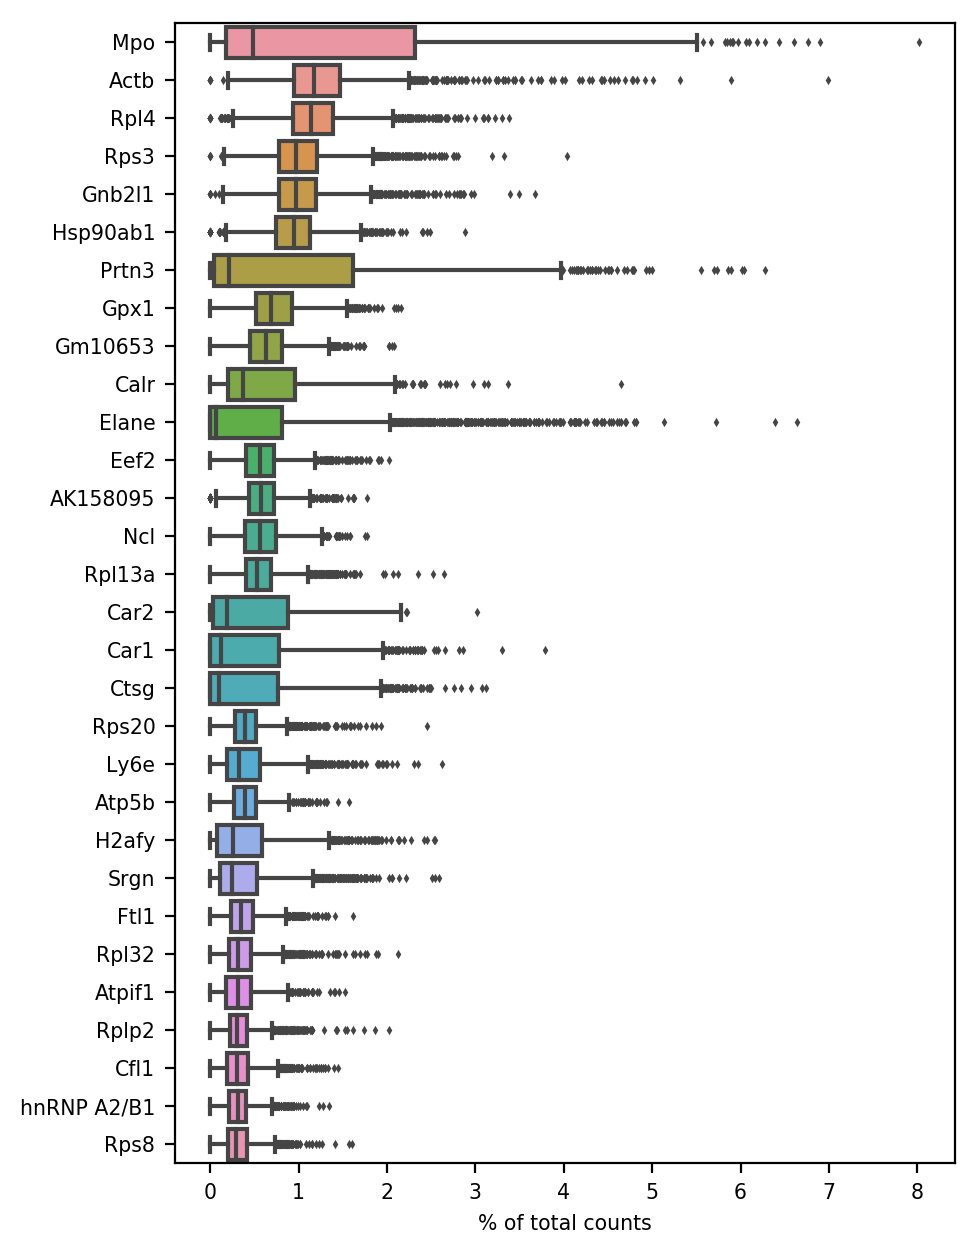

In [17]:
# start with looking at counts in the raw adata object
sc.pl.highest_expr_genes(adata)

... storing 'batch' as categorical


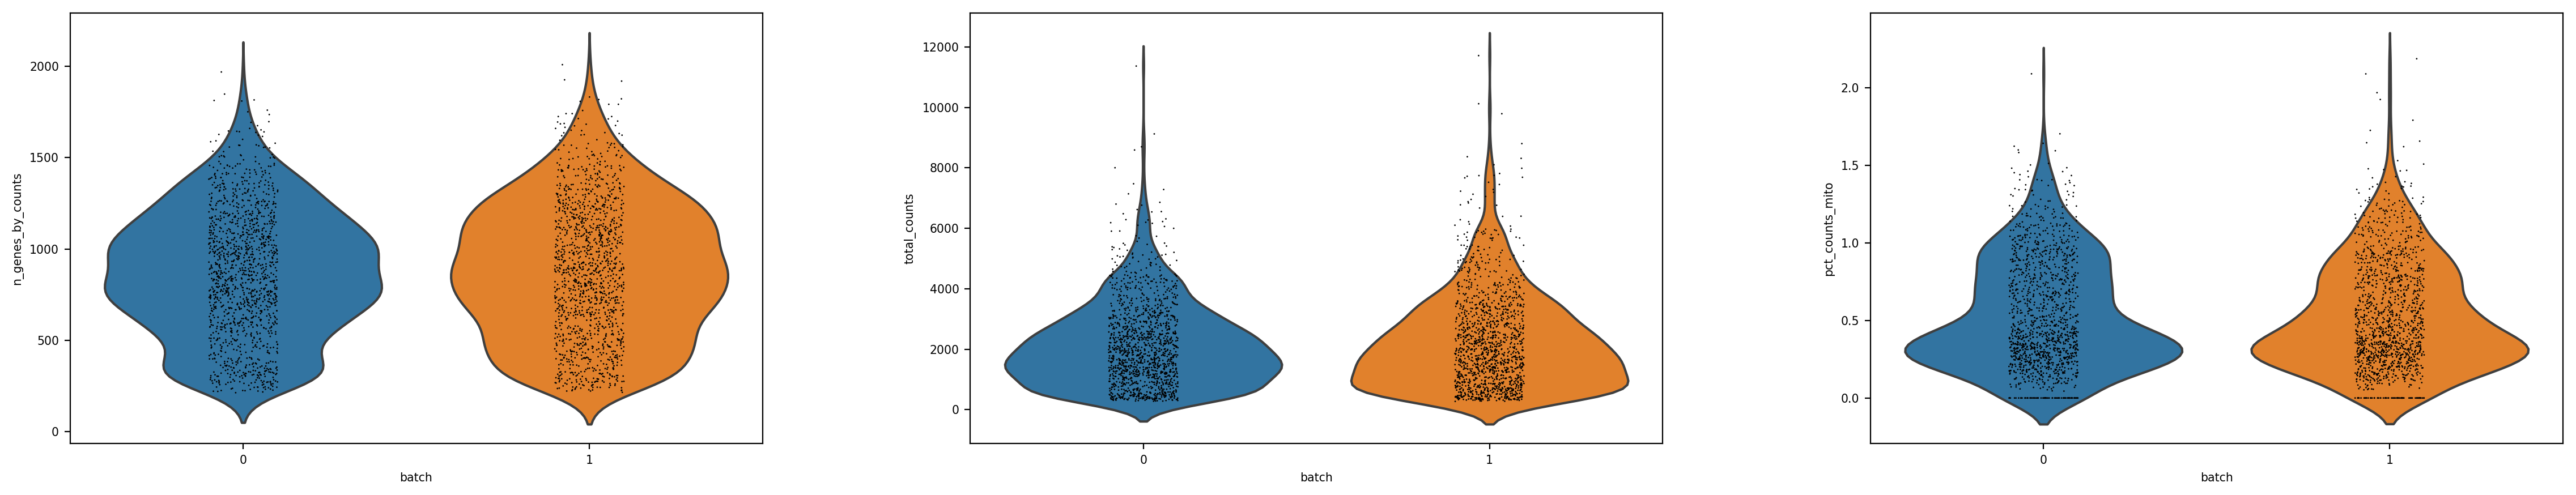

In [18]:
# check out quality metric across batches
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'], groupby='batch')

In [19]:
adata.obs['group'] = np.random.choice(['group_1', 'group_2'], adata.n_obs)
adata.obs['group'] = adata.obs['group'].astype('category')

adata.obs['plate'] = np.random.choice(['plate_1', 'plate_2', 'plate_3'], adata.n_obs)
adata.obs['plate'] = adata.obs['plate'].astype('category')

In [20]:
# visualise as histograms
ipl.interactive_hist(adata, groups=['plate'],
                     keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mito'], 
                     fill_alpha=0.3,
                     plot_width=400, plot_height=400)

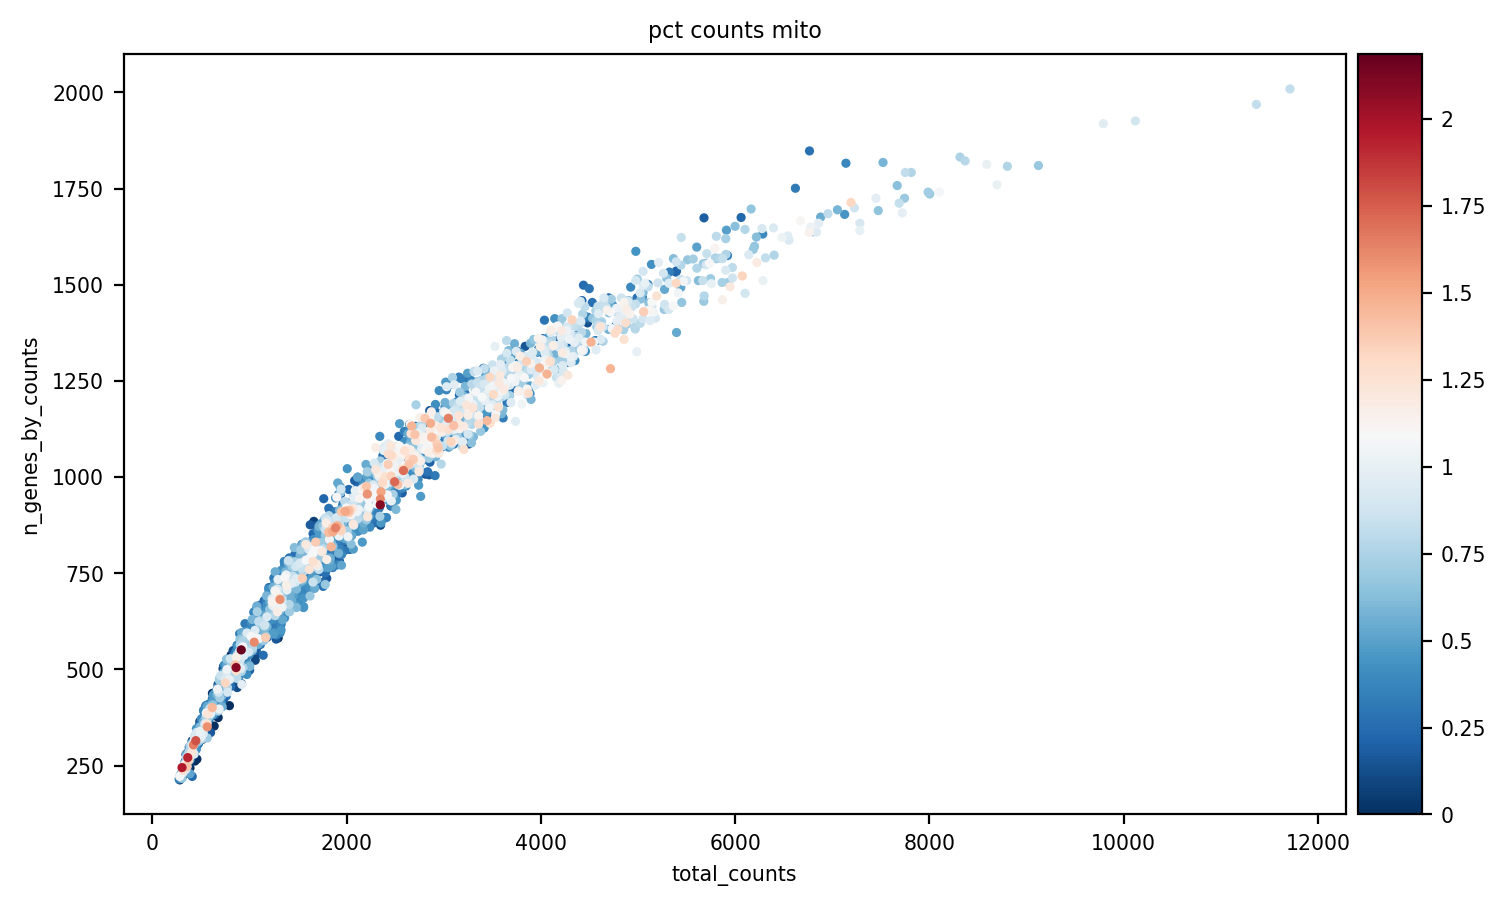

In [21]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mito')

## Filtering

We will filter out the human and the viral genes, and we will look at some quality measures for the actual mouse genes.

In [22]:
# basic filtering of cells and genes
sc.pp.filter_cells(adata, min_genes=200)
# filter based on spliced/unspliced reads per cell
scv.pp.filter_genes(adata, min_counts=20, min_counts_u=10, min_cells=3)

In [23]:
# filter cells based on total counts/n_genes
adata = adata[adata.obs['total_counts'] < 8000].copy()

In [24]:
# filter cells based on mitochondtial activity
adata = adata[adata.obs['pct_counts_mito'] < 2]

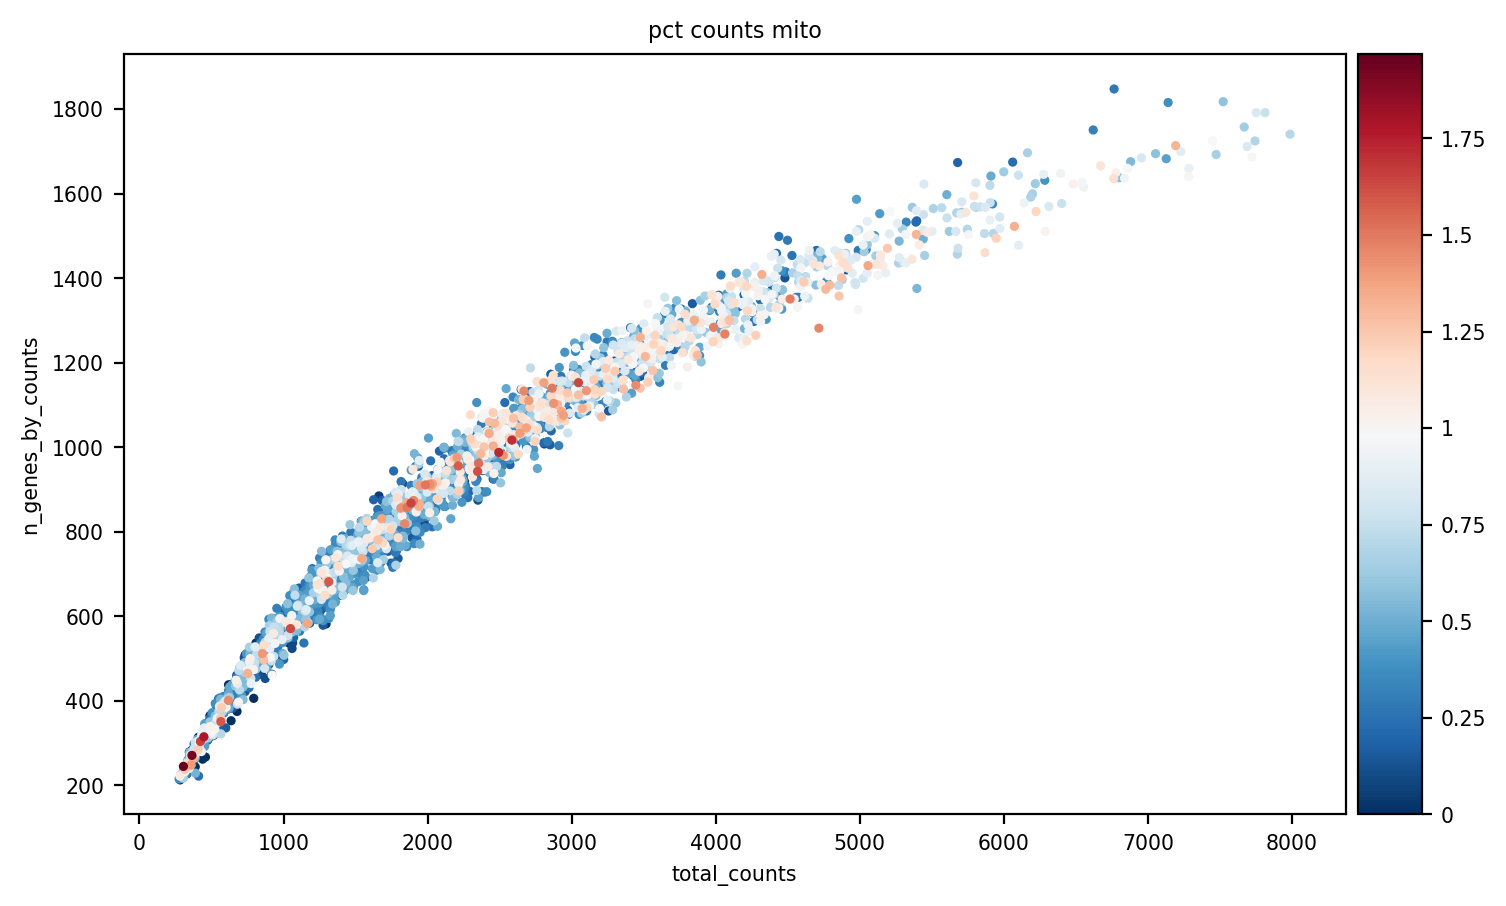

In [25]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mito')

## Normalization

In [26]:
# normalize per cell - we use scvelo here to normalize to initial cell size
scv.pp.normalize_per_cell(adata, use_initial_size=True)

Normalized count data: X.


In [27]:
# log transform and set .raw
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.log1p(adata)

In [28]:
# batch effect removal
sc.pp.combat(adata, key='batch')

Standardizing Data across genes.
found 2 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments
/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:196: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


Adjusting data


In [29]:
# filter on highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

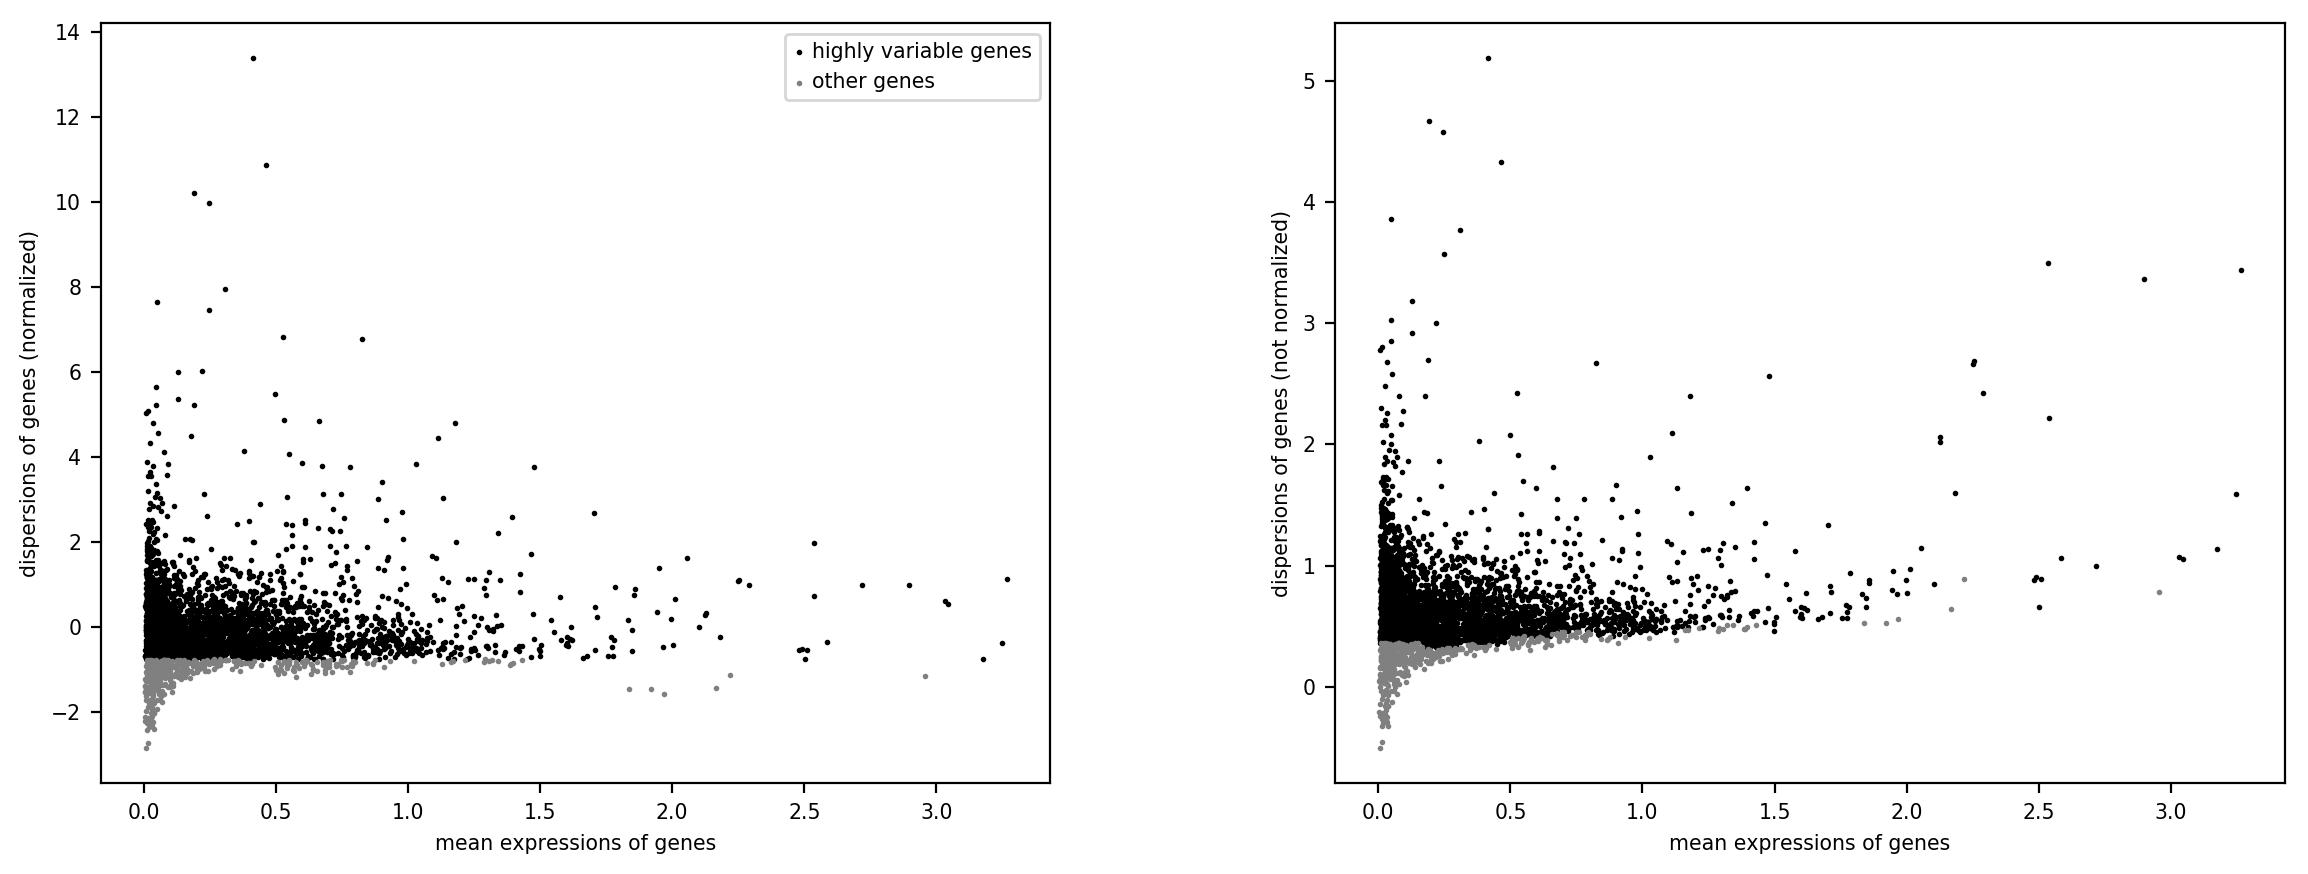

In [30]:
# plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [31]:
# regress out the count depth effect
sc.pp.regress_out(adata, 'total_counts')

/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [32]:
#scale the genes so that they equaly contribute to the PCA
sc.pp.scale(adata)

# Embedding and Clustering

Typical workflow:
- PCA, choose number of components
- Quality assesment in the PCA space
- Compute a KNN graph
- Compute UMAP, force directed layout, tSNE, etc
- Run Louvain or Leiden clustering

In [33]:
# Comptue PCA representation
sc.tl.pca(adata, svd_solver='arpack')

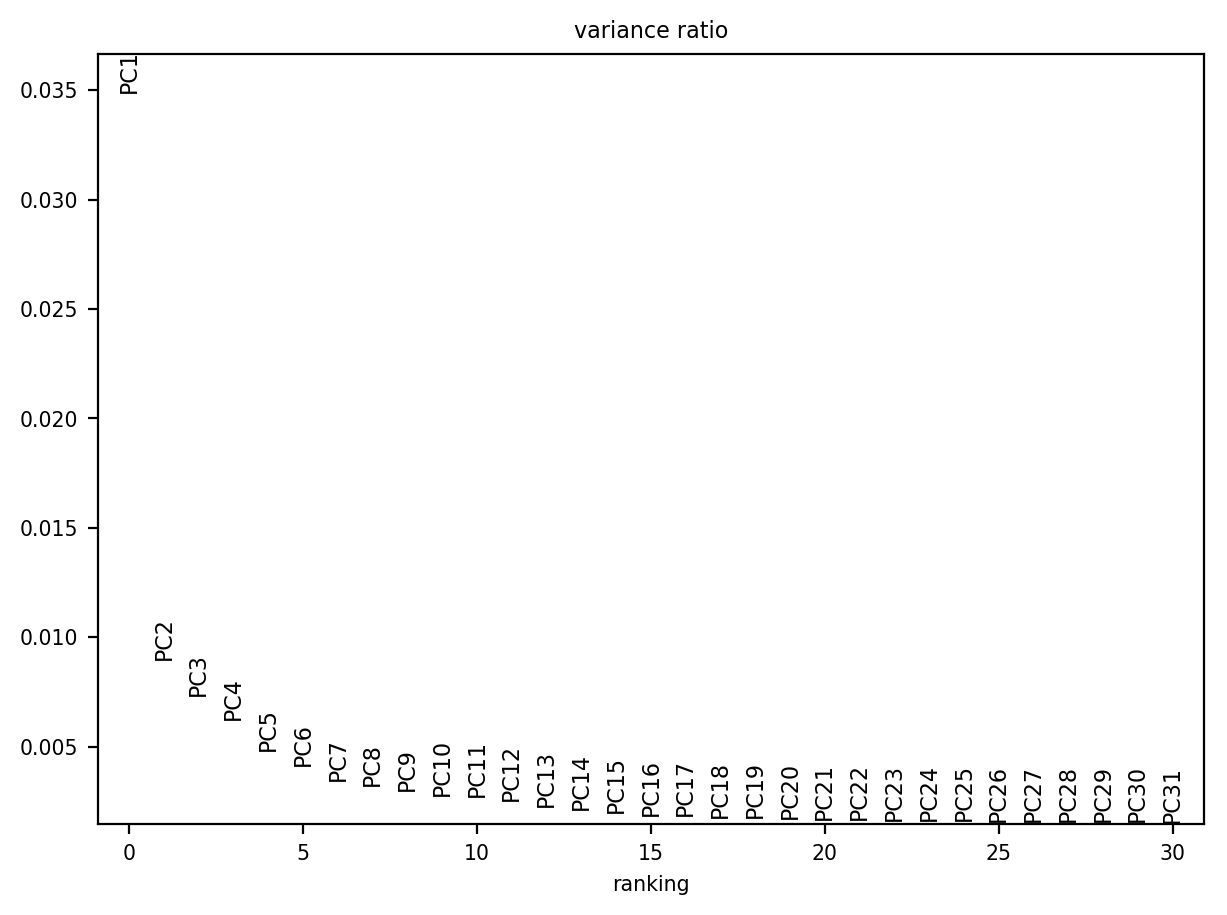

In [34]:
# Look at variance distribution
sc.pl.pca_variance_ratio(adata)

In [35]:
# set a number of pc's to be used in downstream analysis
n_pcs = 11

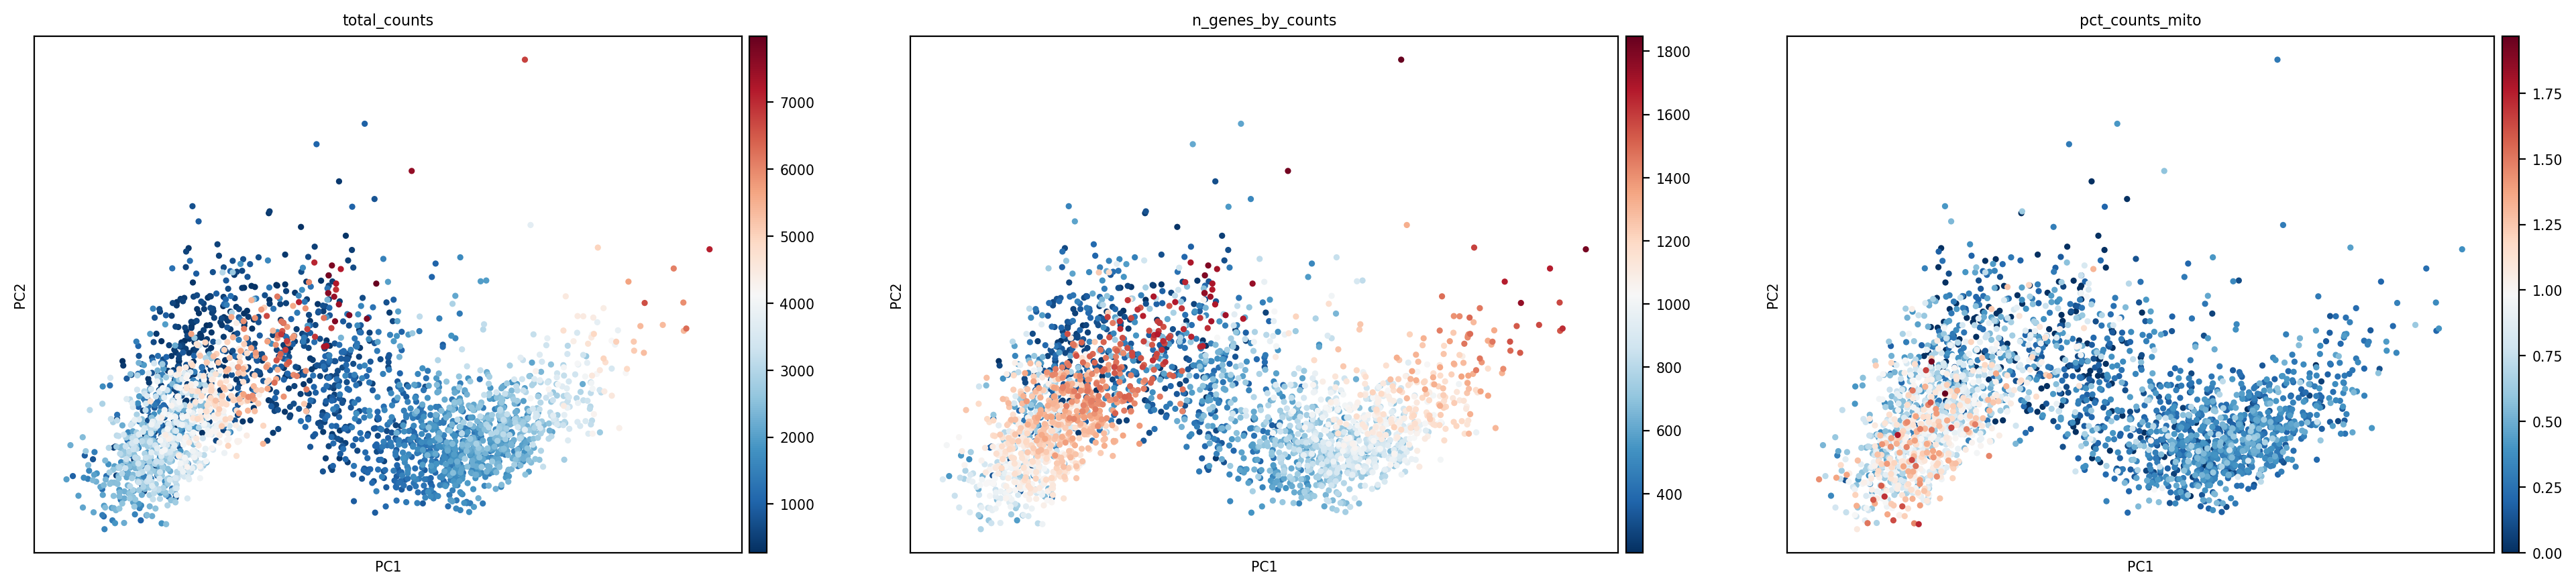

In [36]:
# Look at quality metrics in the PCA plot
sc.pl.pca(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mito'])

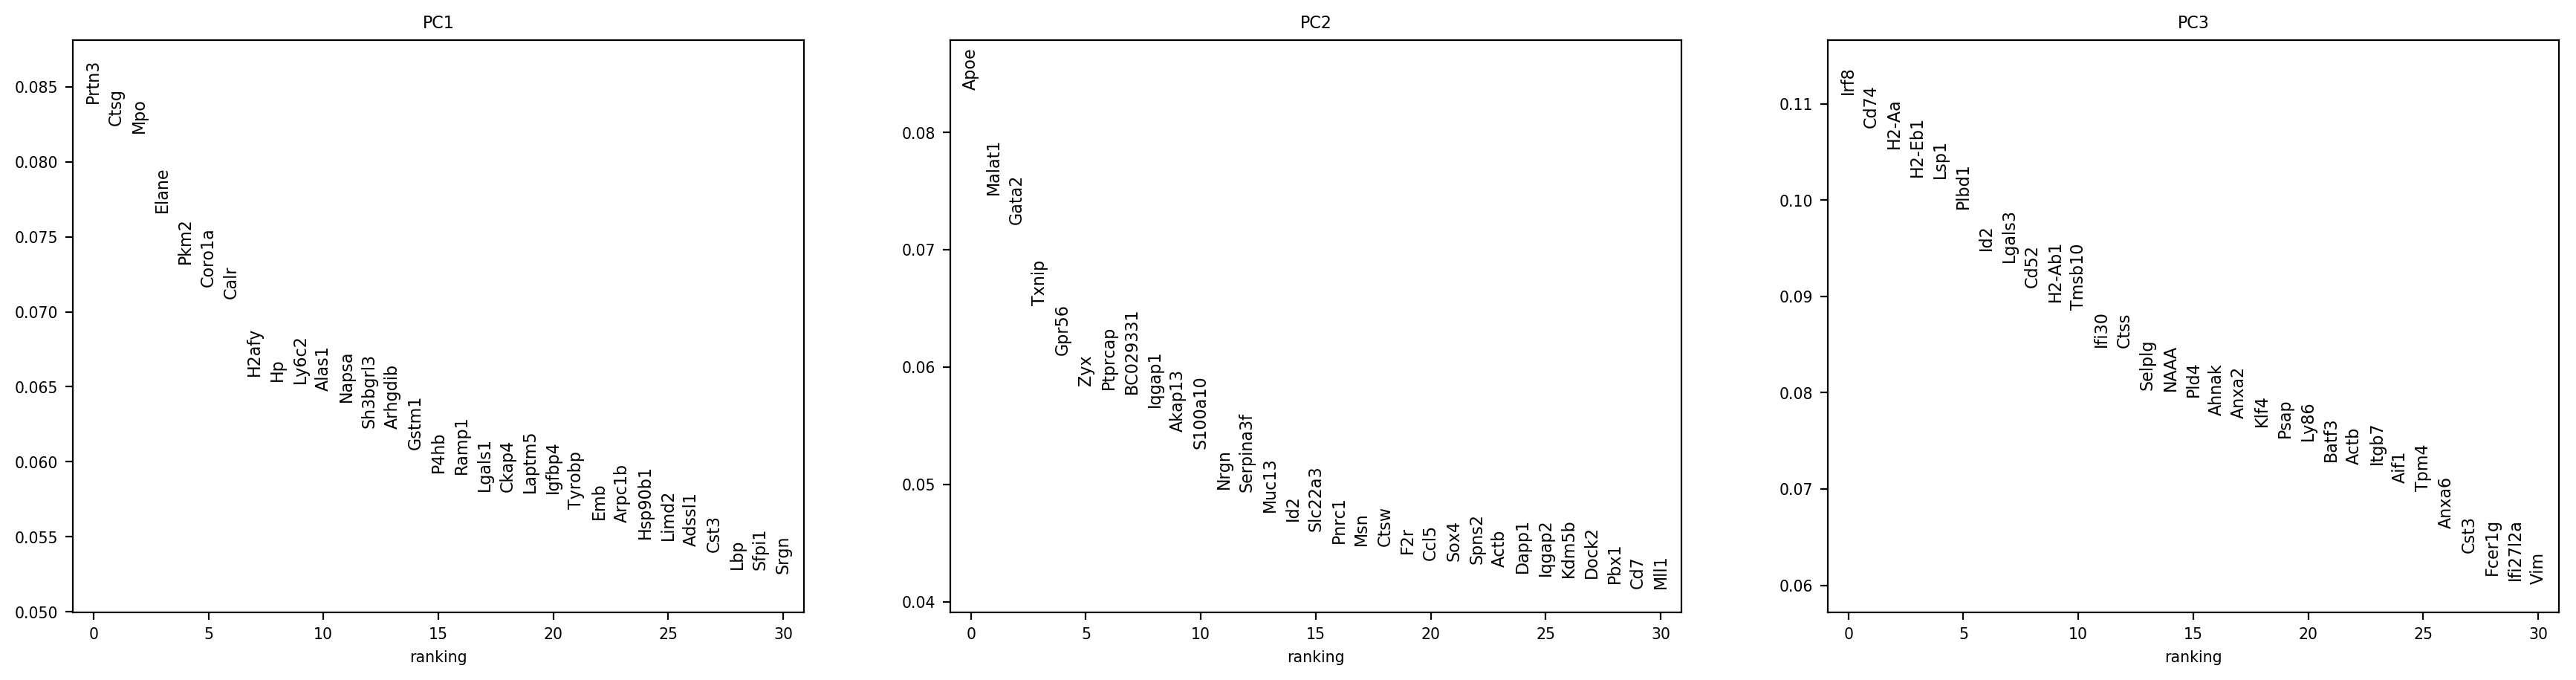

In [37]:
# Check the loadings
sc.pl.pca_loadings(adata)

**Interpretetation:**

In [38]:
# compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs, random_state=42)

In [39]:
# comptue clustering
sc.tl.louvain(adata, resolution=0.2, random_state=42)

In [40]:
# compute UMAP
sc.tl.umap(adata, random_state=42)

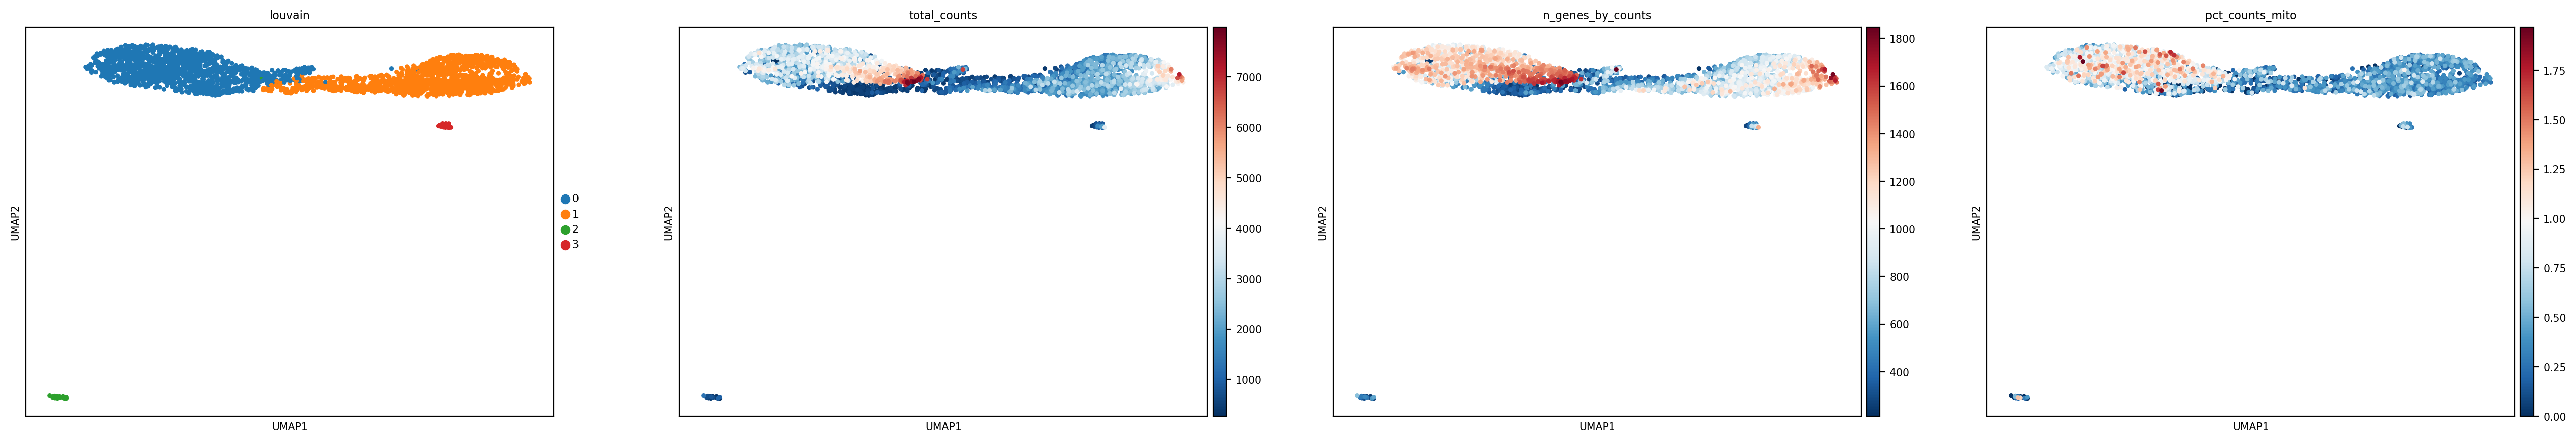

In [41]:
# plot the umap
sc.pl.umap(adata, color=['louvain', 'total_counts', 'n_genes_by_counts', 'pct_counts_mito'])

## Interactive histogram with groups

In [42]:
ipl.thresholding_hist(adata, key='n_genes', categories=dict(cat_1=[0, 500], cat_2=[750, 1250]))

## Highlighting differentially expressed genes

In [43]:
sc.tl.rank_genes_groups(adata, 'louvain')
ipl.highlight_de(adata, cell_keys='batch', legend_loc='bottom_right')

## Selecting 'iroot'

In [44]:
sc.tl.diffmap(adata)
ipl.highlight_indices(adata, key='group', basis='diffmap', components=[1, 4])

In [45]:
adata.uns['iroot'] = 2371
sc.tl.dpt(adata)

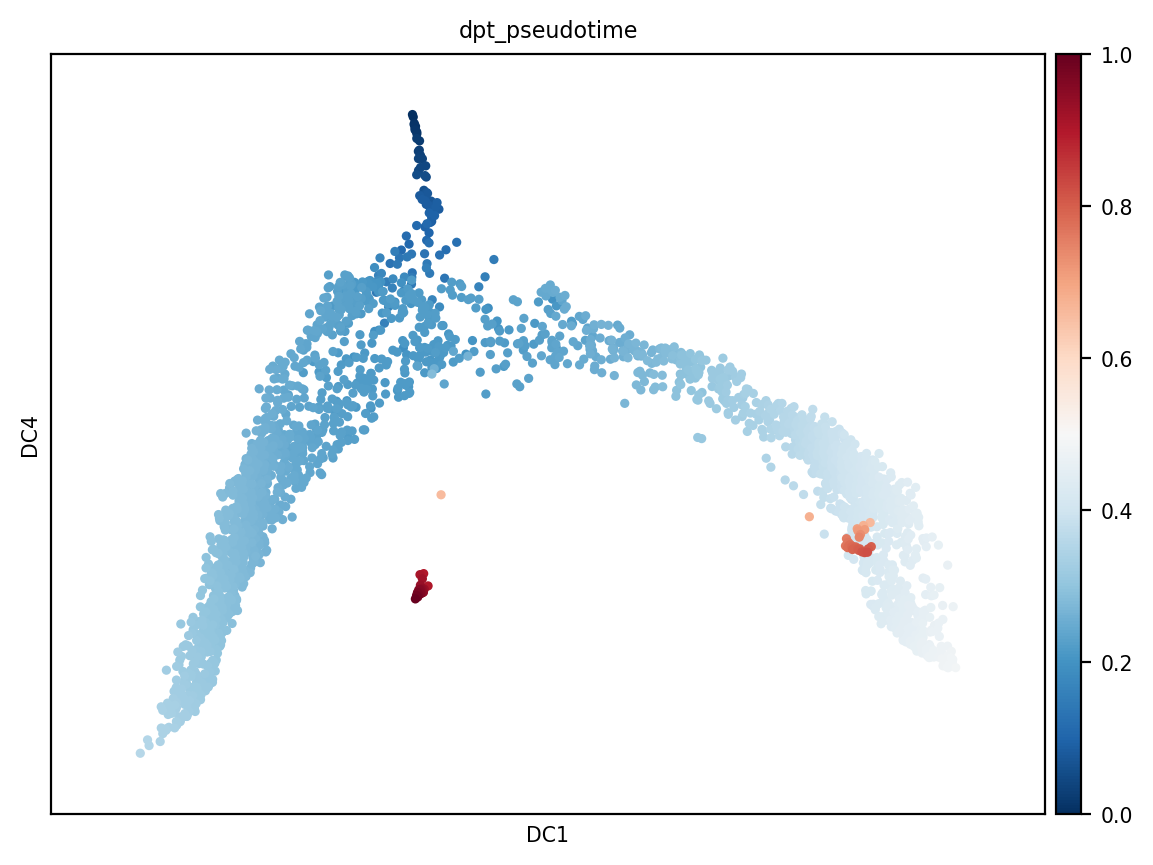

In [46]:
sc.pl.diffmap(adata, color='dpt_pseudotime', components=[1, 4])

In [ ]:
ipl.link_plot(adata, bases=['diffmap', 'umap'], components=[[1, 4], [1, 2]],
              genes=list(map(lambda r: r[0], adata.uns['rank_genes_groups']['names']))[:10],
              cutoff=True,
              key='louvain', distance='dpt', legend_loc='top_right')

## Velocity plot

In [ ]:
ipl.velocity_plot(adata, genes=adata.var_names[:1], paths=[['0', '1', '2'], ['0', '1', '3']])